# Лабораторная работа №3. Метод главных компонент
###### Выполнил студент группы ПВ202 Нехаенко Владимир
###### Вариант 9. Данные о смертности при сердечной недостаточности (heart_failure_clinical_records_dataset.csv)

In [220]:
import pandas as pd

df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
deaths = df['DEATH_EVENT']
df = df.drop(columns=['time', 'DEATH_EVENT'])
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0
...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1


#### Вспомогательные функции для визуализации

In [221]:
from matplotlib.colors import Normalize, to_rgb
from pandas import DataFrame
import matplotlib.cm as cm
from matplotlib import pyplot as plt


def visualize(data_frame: DataFrame, x_name, y_name, x_label, y_label, colors):
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    for index, row in data_frame.iterrows():
        plt.plot(row[x_name], row[y_name], marker='x' if deaths[index] else 'o', color=colors[index])

    plt.show()


def print_graphics(data_frame, clustering_labels=None):
    if clustering_labels is not None:
        norm = Normalize(vmin=0, vmax=max(clustering_labels))
        mapping = cm.ScalarMappable(norm=norm, cmap=cm.hot)

        colors = [mapping.to_rgba(cluster_num) for cluster_num in clustering_labels]
    else:
        colors = [to_rgb(123) for _ in range(len(data_frame))]

    visualize(data_frame, 'ejection_fraction', 'creatinine_phosphokinase', 'Фракция выброса', 'Креатинкиназа', colors)
    visualize(data_frame, 'ejection_fraction', 'platelets', 'Фракция выброса', 'Тромбоциты', colors)
    visualize(data_frame, 'serum_sodium', 'platelets', 'Сывороточный натрий', 'Тромбоциты', colors)

## Кластеризация из 2-й лабораторной работы

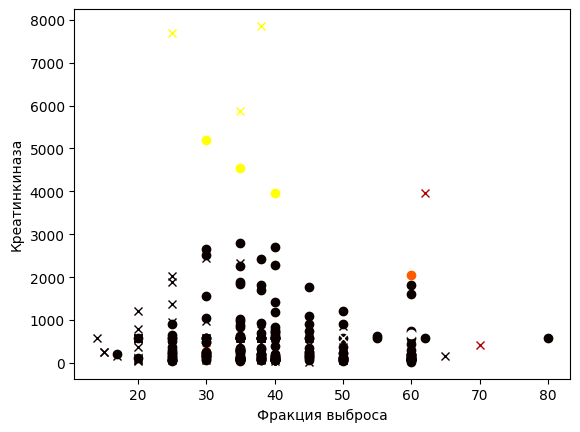

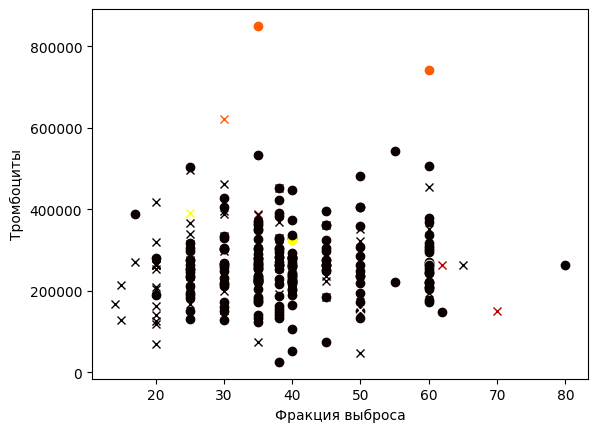

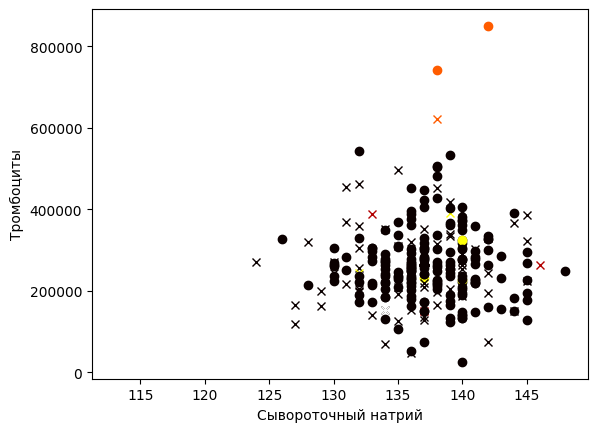

In [222]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

data = StandardScaler().fit_transform(df.values)
clustering_2_lab = AgglomerativeClustering(n_clusters=5, metric='mahalanobis', linkage='complete')
clustering_2_lab.fit(data)

print_graphics(df, clustering_2_lab.labels_)

## Кластеризация с предварительной обработкой методом главных компонент

#### Функция, реализующая кластеризацию с предворительной обработкой данных методом главных компонент

In [223]:
from sklearn.decomposition import PCA


def pca_clustering(dataframe, n_components: int, n_clusters: int = 5):
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(scaler.fit_transform(dataframe.values))

    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='mahalanobis', linkage='complete')
    clustering.fit(data)

    return clustering

#### Кластеризация с МГК (2 компоненты)

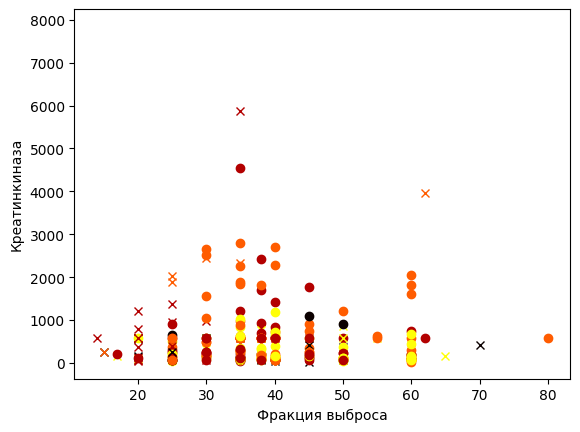

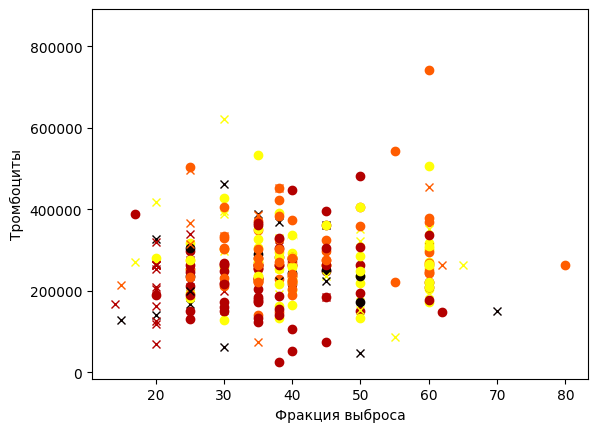

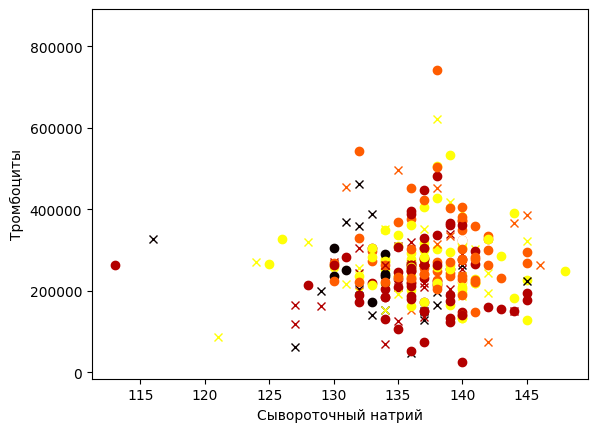

In [224]:
clustering_pca_2 = pca_clustering(df, 2)

print_graphics(df, clustering_pca_2.labels_)

#### Кластеризация с МГК (5 компонент)

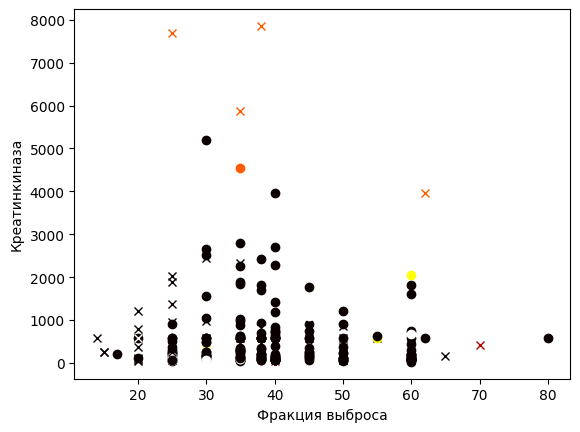

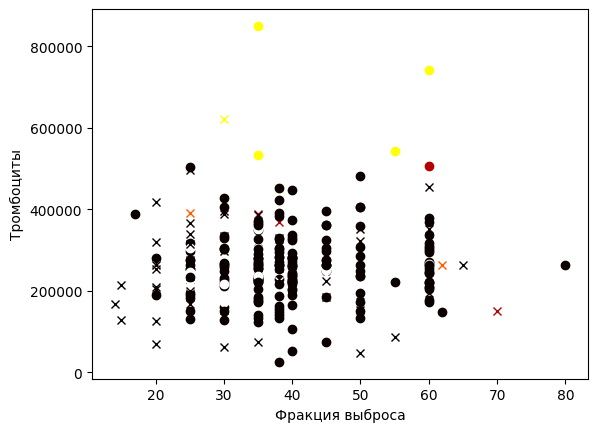

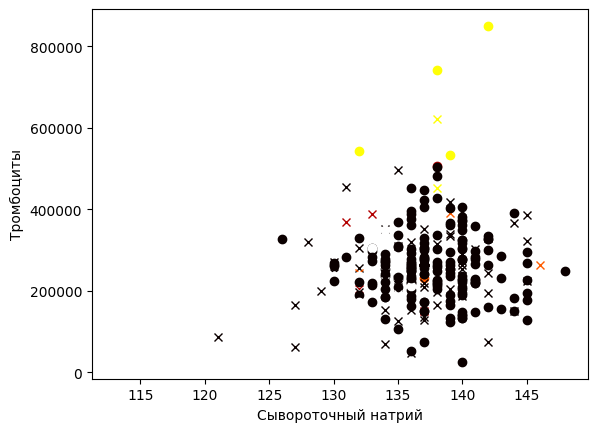

In [225]:
clustering_pca_5 = pca_clustering(df, 5)
print_graphics(df, clustering_pca_5.labels_)

## Оценка качества кластеризации

In [226]:

from typing import Tuple
from typing import List
from sklearn.metrics import davies_bouldin_score, silhouette_score

metrics = [
    ('Индекс Дэвиса-Булдина', davies_bouldin_score),
    ('Коэффициент силуэта', silhouette_score),
]


def score_clustering(data_frame: DataFrame, clusterings: List[Tuple[str, AgglomerativeClustering]]) -> DataFrame:
    scores = []

    for metric in metrics:
        scores.append([metric[1](data_frame.values, clustering[1].labels_) for clustering in clusterings])

    return DataFrame(
        scores,
        columns=[clustering[0] for clustering in clusterings],
        index=[metric[0] for metric in metrics]
    )


score_clustering(df, [
    ('Лабораторная 2', clustering_2_lab),
    ('Метод главных компонент (2 компоненты)', clustering_pca_2),
    ('Метод главных компонент (5 компонент)', clustering_pca_5),
])

,Лабораторная 2,Метод главных компонент (2 компоненты),Метод главных компонент (5 компонент)
Индекс Дэвиса-Булдина,9.610180,25.665643,6.313233
Коэффициент силуэта,-0.177095,-0.083106,-0.216043


Оценка силуэта, или коэффициент силуэта, - это оценочный показатель, который дает результат в диапазоне от -1 до 1. Оценка, близкая к 1, указывает на то, что точка данных очень компактна внутри кластера, к которому она принадлежит, и находится далеко от других кластеров. Оценка, близкая к -1, означает наименьшую или наихудшую важность точки данных. Оценка, близкая к 0, означает перекрывающиеся кластеры.

Оценка индекса Дэвиса-Булдина определяется как средняя мера сходства каждого кластера с наиболее похожим кластером, где сходство представляет собой отношение расстояний внутри кластера к расстояниям между кластерами. Таким образом, кластеры, расположенные дальше друг от друга и менее рассредоточенные, дадут лучший результат. Минимальный балл равен 0, меньшие значения указывают на лучшую кластеризацию.

## Вывод

В ходе лабораторной работы, был использован метод главных компонент для уменьшения числа признаков. Наилучшее значение индекса Дэвиса-Булдина, характеризующего внутрикластерное расстояние, достигается при построении 5 признаков методом главных компонент, наихудшее при построении 2-х признаков, можно предположить что это происходит из-за потери информации, так как количество изначальных признаков намного больше 2. Оценка силуэта, характеризующая межкластерное расстояние, наилучшая при построении 2-х признаков методом главных компонент.